## Test different registration methods 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift

%matplotlib inline

In [2]:
def estimate_transform_itk(moving, fixed, tx):
    from SimpleITK import GetImageFromArray
    moving_ = GetImageFromArray(moving.astype('float32'))
    fixed_ = GetImageFromArray(fixed.astype('float32'))
    return tx.Execute(moving_, fixed_)

In [3]:
from pyklb import readfull
from glob import glob
fnames = glob('/nobackup/ahrens/davis/data/raw/20160608/6dpf_cy171xcy221_f2_omr_2_20160608_200632/*.klb')
fnames.sort()

moving = readfull(fnames[-1])
fixed = np.array([readfull(f) for f in fnames[0:5]]).mean(0)

## Make synthetic data

In [4]:
span = np.linspace(-3,3,100)
x,y,z = np.meshgrid(span, span, span)
synth = np.exp(-x**2 - y**2 - z**2)
fixed_s = synth
moving_s = shift(synth, [-.5, -1.5, 7.5])

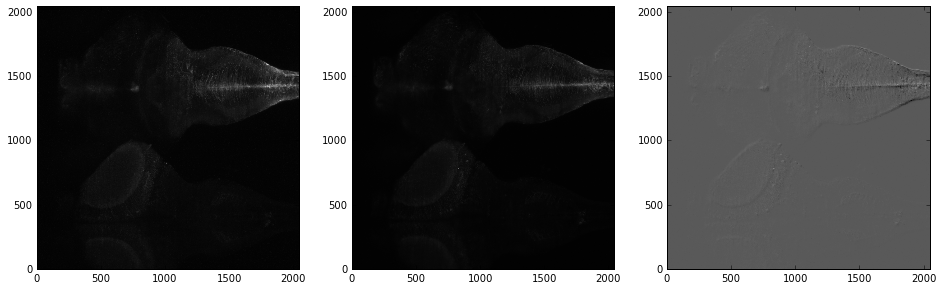

In [109]:
fig, axs = plt.subplots(ncols=3)
fig.set_figheight(16)
fig.set_figwidth(16)
roi = (slice(0, -1), slice(0, -1), slice(0, -1))

fixed_r = fixed[roi]
moving_r = moving[roi]
axs[0].imshow(moving_r.max(0), cmap='gray', aspect=1, origin='lower')
axs[1].imshow(fixed_r.max(0), cmap='gray', aspect=1, origin='lower')
axs[2].imshow(fixed_r.max(0) - moving_r.max(0), cmap='gray', aspect=1, origin='lower')

## Estimate affine transform using sitk

In [ ]:
%%time

import SimpleITK as sitk
r = sitk.ImageRegistrationMethod()
r.SetMetricAsMattesMutualInformation(numberOfHistogramBins=32)
r.SetOptimizerAsLBFGSB(maximumNumberOfCorrections=10, numberOfIterations=1000)
r.SetMetricSamplingStrategy(r.RANDOM)
r.SetMetricSamplingPercentage(.25)
tx = sitk.TranslationTransform(3)

r.SetInitialTransform(tx)
r.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2])
r.SetSmoothingSigmasPerLevel(smoothingSigmas=[3, 1])

tx = estimate_transform_itk(fixed_r, moving_r, r)

In [55]:
tx.GetParameters()

(13.077581617337605, -11.510267456633432, 0.43211746064152773)

## Estimate affine transform using dipy.align

In [117]:
%%time
from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration 
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

metric = MutualInformationMetric(32, .1)
factors = [4, 2, 1]
sigmas = [3.0, 1.0, 0.0]
level_iters = [10000, 1000] 
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

result = affreg.optimize(fixed_r, moving_r, transform=TranslationTransform3D(), params0=None)

Optimizing level 1 [max iter: 10000]
Optimizing level 0 [max iter: 1000]
CPU times: user 7min 39s, sys: 55.9 s, total: 8min 35s
Wall time: 4min 40s


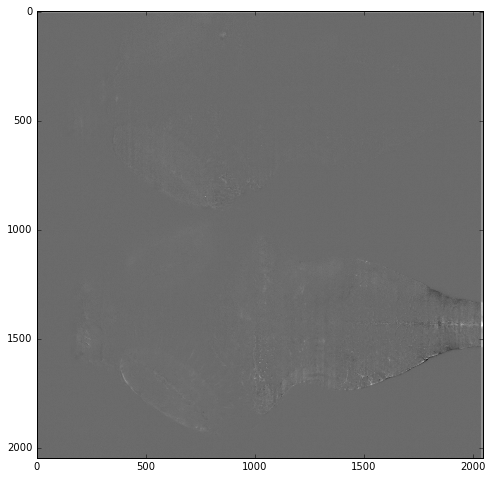

In [115]:
plt.figure(1,(8,8))
z = 25
plt.imshow(fixed_r[z] - result.transform(moving_r)[z], cmap='gray')

### Try SyN with dipy

In [1]:
%%time
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration, DiffeomorphicMap
from dipy.align.metrics import CCMetric
from scipy.ndimage.interpolation import shift
from numpy import linspace, meshgrid, exp
from skimage.transform import warp, swirl

# make synthetic data
span = linspace(-3,3,50)
x,y,z = meshgrid(span, span, span)
fixed = exp(-x**2 - y**2 - z**2)
moving = shift(fixed, [-.5, -2.5, 7.5])
moving = swirl(moving, strength=10)

# this works
crop_0 = [slice(0, None), slice(0, None), slice(0, None)]

# this causes division by 0 error
crop_1 = [slice(0, 20), slice(0, None), slice(0, None)]

# this crashes the kernel
crop_2 = [slice(0, 13), slice(0, None), slice(0, None)]

metric = CCMetric(3)
sdr = SymmetricDiffeomorphicRegistration(metric)

mapping = sdr.optimize(fixed[crop_0], moving[crop_0])

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0
CPU times: user 10 s, sys: 216 ms, total: 10.2 s
Wall time: 10.4 s


In [ ]:
fig, axs = plt.subplots(nrows=2)
fig.set_figheight(16)
fig.set_figwidth(16)
z = 32
axs[0].imshow(fixed_r[z] - result.transform(moving_r)[z], cmap='gray')
axs[1].imshow(fixed_r[z] - mapping.transform(moving_r)[z], cmap='gray')

## Test SyN with cell-like data

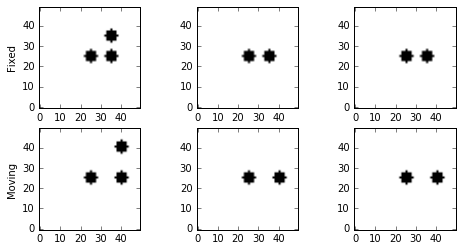

In [183]:
import matplotlib.pyplot as plt
from numpy import linspace, meshgrid, exp, zeros
from scipy.ndimage.interpolation import shift
from skimage.transform import swirl
from skimage.morphology import ball
from scipy.signal import fftconvolve
%matplotlib inline

# make synthetic data
#span = linspace(-10,10,50)
#x,y,z = meshgrid(span, span, span)
#kern = exp(-z**2 - y**2 - x**2)
kern = ball(3)
dims = [50,50,50]
pos_fixed = zeros(dims)
pos_fixed[25,25,25] = 1
pos_fixed[25,25,35] = 1
pos_fixed[25,35,35] = 1
fixed = fftconvolve(pos_fixed, kern, mode='same')
pos_moving = zeros(dims)
pos_moving[25,25,25] = 1
pos_moving[25,25,40] = 1
pos_moving[25,40,40] = 1
moving = fftconvolve(pos_moving, kern, mode='same')

fig, axs = plt.subplots(ncols = len(moving.shape), nrows=2,  figsize = (8,4))
[a.imshow(fixed.max(ind), cmap='gray_r', origin='lower') for ind, a in enumerate(axs[0])]
axs[0][0].yaxis.set_label_text('Fixed')
[a.imshow(moving.max(ind), cmap='gray_r', origin='lower') for ind, a in enumerate(axs[1])]
axs[1][0].yaxis.set_label_text('Moving')

In [180]:
%%time
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration, DiffeomorphicMap
from dipy.align.metrics import CCMetric

metric = CCMetric(3)
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters=[1000,1000,1000], ss_sigma_factor=.02)
mapping = sdr.optimize(fixed, moving)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.020000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.020000.
Optimizing level 2
Optimizing level 1
Optimizing level 0
CPU times: user 11.3 s, sys: 2 ms, total: 11.3 s
Wall time: 11.3 s


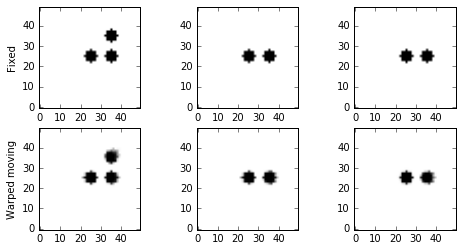

In [181]:
fig, axs = plt.subplots(ncols = len(moving.shape), nrows=2,  figsize = (8,4))
[a.imshow(fixed.max(ind), cmap='gray_r', origin='lower') for ind, a in enumerate(axs[0])]
axs[0][0].yaxis.set_label_text('Fixed')

[a.imshow(mapping.transform(moving).max(ind), cmap='gray_r', origin='lower') for ind, a in enumerate(axs[1])]
axs[1][0].yaxis.set_label_text('Warped moving')

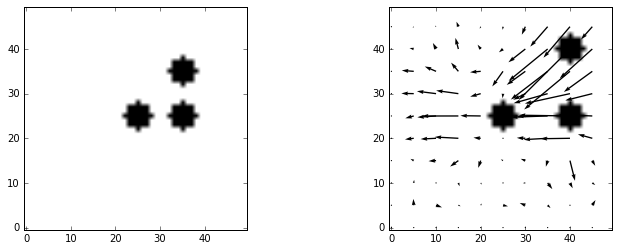

In [184]:
fig, axs = plt.subplots(ncols = 2, nrows=1,  figsize = (12,4))
z = 25
ds = 5
axs[0].imshow(fixed[z,:,:], cmap='gray_r', origin='lower')
axs[1].imshow(moving[z,:,:], cmap='gray_r', origin='lower')
axs[1].quiver(np.arange(0,50,ds), np.arange(0,50,ds), mapping.forward[z,::ds,::ds,2], mapping.forward[z,::ds,::ds,1])

# Get images from an unparalyzed fish


In [190]:
import numpy as np
import matplotlib.pyplot as plt
from pyklb import readfull
from glob import glob
%matplotlib inline
fnames = glob('/nobackup/ahrens/davis/data/raw/20160526/7dpf_cy171xcy221_f1_omr_1_20160526_183631/*.klb')
fnames.sort()
fixed_f = np.array([readfull(f) for f in fnames[0:5]]).mean(0)

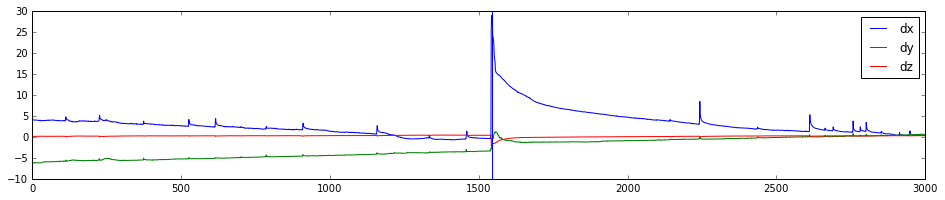

In [351]:
motion = np.load('/nobackup/ahrens/davis/data/proc/20160526/7dpf_cy171xcy221_f1_omr_1_20160526_183631/reg/translation_params.npy')
plt.figure(1,(16,3))
plt.plot(motion.T[0:3000])
plt.legend(['dx', 'dy', 'dz'])
t_move = np.argmax(motion[0,0:3000])
plt.axvline(t_move)
moving_f = readfull(fnames[t_move+10])

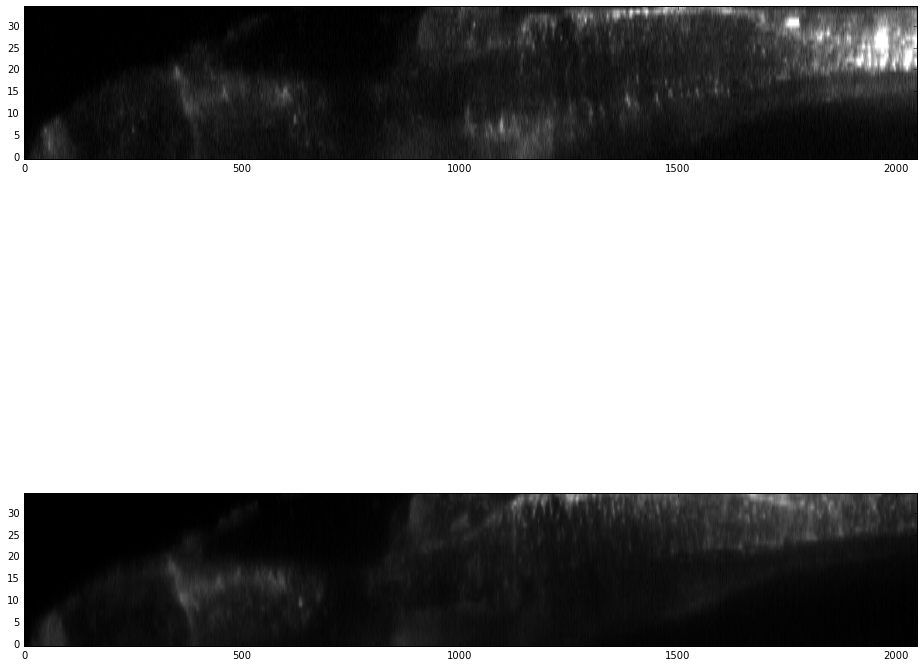

In [352]:
fig, axs = plt.subplots(nrows=2,figsize=(16,16))
z = 10
axs[0].imshow((moving_f[:,550,:]), cmap='gray', origin='lower', aspect=10, clim=[100,635])
axs[1].imshow((fixed_f[:,550,:]), cmap='gray', origin='lower', aspect=10, clim=[100,635])

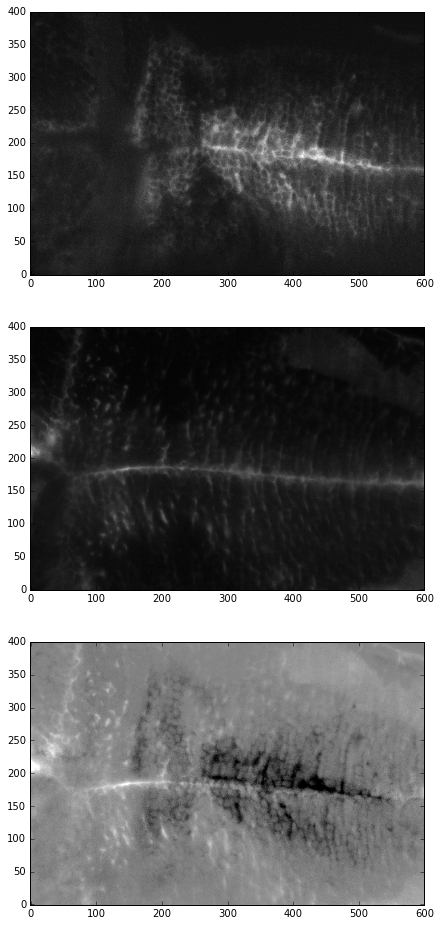

In [295]:
roi = (28, slice(400, 800), slice(1000, 1600))
from scipy.stats import zscore
fixed_r = fixed_f[roi]
moving_r = moving_f[roi]
fig, axs = plt.subplots(nrows=3, figsize=(16,16))
axs[0].imshow(zscore(moving_r, axis=None), cmap='gray', aspect=1, origin='lower')
axs[1].imshow(zscore(fixed_r, axis=None), cmap='gray', aspect=1, origin='lower')
axs[2].imshow(zscore(fixed_r - moving_r, axis=None), cmap='gray', aspect=1, origin='lower', clim=[-5,5])

In [296]:
from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration 
from dipy.align.transforms import TranslationTransform2D

metric = MutualInformationMetric(32, .1)
factors = [4, 2, 1]
sigmas = [3.0, 1.0, 0.0]
level_iters = [10000, 1000] 
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

result = affreg.optimize(fixed_r, moving_r, transform=TranslationTransform2D(), params0=None)

Optimizing level 1 [max iter: 10000]
Optimizing level 0 [max iter: 1000]


In [286]:
%%time
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration, DiffeomorphicMap
from dipy.align.metrics import CCMetric
metric = CCMetric(len(fixed_r.shape))
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters=[1000,1000,1000])
mapping = sdr.optimize(fixed_r, moving_r, prealign=result.affine)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0
CPU times: user 35 s, sys: 247 ms, total: 35.3 s
Wall time: 33.7 s


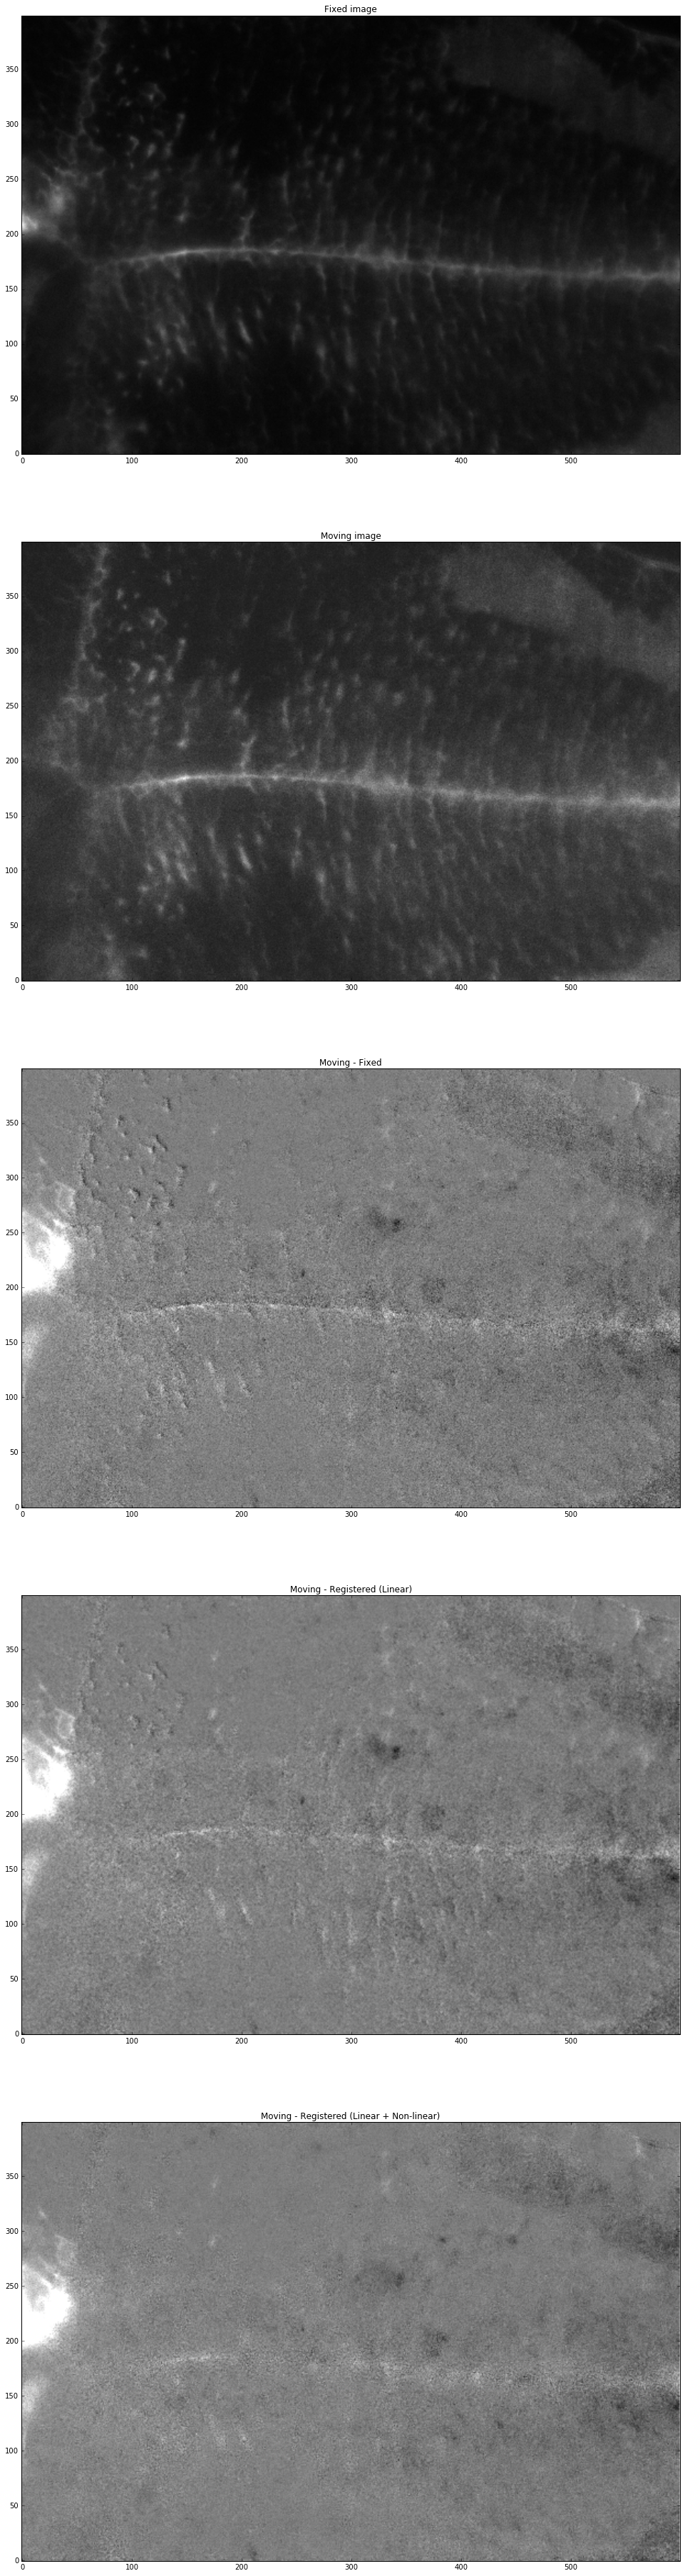

In [288]:
fig, axs = plt.subplots(nrows=5, figsize=(64,64))

x = np.arange(fixed_r.shape[1])
y = np.arange(fixed_r.shape[0])
ds = 4

axs[0].imshow(zscore(fixed_r, None), cmap='gray', aspect=1, origin='lower')
axs[0].title.set_text('Fixed image')
axs[1].imshow(zscore(moving_r, None), cmap='gray', aspect=1, origin='lower')
axs[1].title.set_text('Moving image')
axs[2].imshow(zscore(fixed_r - moving_r, None), cmap='gray', aspect=1, origin='lower', clim=[-5,5])
axs[2].title.set_text('Moving - Fixed')
axs[3].imshow(zscore(fixed_r - result.transform(moving_r), None), cmap='gray', aspect=1, origin='lower', clim=[-5,5])
axs[3].title.set_text('Moving - Registered (Linear)')
axs[4].imshow(zscore(fixed_r - mapping.transform(moving_r), None), cmap='gray', aspect=1, origin='lower', clim=[-5,5])
axs[4].title.set_text('Moving - Registered (Linear + Non-linear)')


## A separate test on area postrema

In [2]:
import numpy as np
import thunder as td
import matplotlib.pyplot as plt
from scipy.stats import zscore
from glob import glob

in_dir = '/nobackup/ahrens/davis/data/raw/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/'
reg_params = np.load('/nobackup/ahrens/davis/data/proc/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/reg/translation_params.npy')
out_dir = '/nobackup/ahrens/davis/data/proc/20160608/6dpf_cy171xcy221_f1_omr_1_20160608_170933/'
raw_mean = np.load(out_dir + 'raw_mean.npy')

def klb_loader(f, roi=None):
    from pyklb import readfull
    from pyklb import readroi
    from numpy import squeeze
    if roi:
        return readroi(f, roi[0], roi[1])
    else:
        return readfull(f)

fnames = glob(in_dir + '*.klb')
fnames.sort()

reg_bc = sc.broadcast(reg_params)

def register(ims, reg_params):
    from scipy.ndimage.interpolation import affine_transform
    from numpy import eye
    def resample(v):
        return affine_transform(v[1].astype('float32'), eye(3), reg_params[:,v[0][0]][-1::-1], mode='reflect')
        
    txed = ims.map(resample, with_keys=True)
    return txed

In [ ]:
roi = ([32, 350, 1800], [32, 700, 1950])
ims = td.images.fromlist(fnames, accessor=lambda v: klb_loader(v, roi), engine = sc, npartitions=len(fnames)).median_filter()
ims_txed = register(ims, reg_bc.value)

In [ ]:
plt.imshow(ims.first()[0])

In [ ]:
%%time
ims_txed.cache()
ims_txed.count()

In [ ]:
from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration 
from dipy.align.transforms import TranslationTransform2D

metric = MutualInformationMetric(32, .1)
factors = [4, 2, 1]
sigmas = [3.0, 1.0, 0.0]
level_iters = [10000, 1000] 
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

affed = ims_txed.map(lambda v: affreg.optimize(ref, np.squeeze(v), transform=TranslationTransform2D(), params0=None).transform(np.squeeze(v)))

In [ ]:
affed.cache()
affed.count()

In [ ]:
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
ref = np.squeeze(ims_txed[0:5,0,:,:].mean().toarray())
metric = CCMetric(len(ref.shape))
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters=[1000,1000,1000])

In [ ]:
warped = ims_txed.map(lambda v: sdr.optimize(ref, np.squeeze(v)).transform(np.squeeze(v)))
warped.cache()
warped.count()

In [ ]:
mx_lin = ims_txed.max()
mx_warped = warped.max()
mx_affed = affed.max()

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(16,16))
axs[0].imshow(mx_lin.toarray(), cmap='hot', interpolation='None')
axs[0].title.set_text('Correction for translation (whole-brain)')
axs[1].imshow(mx_affed.toarray(), cmap='hot', interpolation='None')
axs[1].title.set_text('Correction for translation (roi)')
axs[2].imshow(mx_warped.toarray(), cmap='hot', interpolation='None')
axs[2].title.set_text('Correction for warping (roi)')